In [87]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Taxi Orders Time Series Forecasting

### Plan of reasearch
1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters.
4. Test the data using the test sample and provide a conclusion.

<a id="step1"></a>
# 1. Preparation

In [67]:
#check data, assign datetime column as index, convert to datetime object
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=True)

#check if data is sorted
print(data.index.is_monotonic)

#check info
data.info()

#check first few rows
data.head()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Not much needs to be done to our dataset. Since we need to determine how to attract more users during peak hours, we first need to resample our data to be hourly.

In [68]:
#resample by hour, aggregation = sum
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Now that we have our data, we can analyze it.

# 2. Analysis

We'll attempt to find our trend and seasonality in our data. Residuals doesn't give any meaningful information, so we'll exclude that.

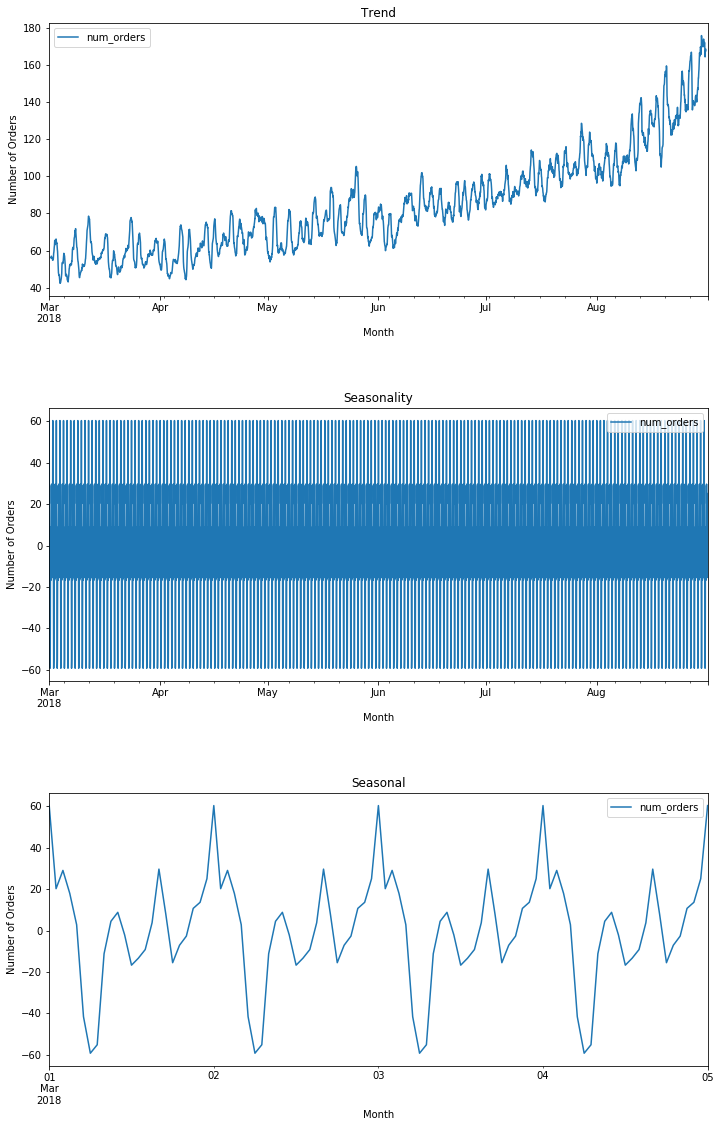

In [69]:
#get different attributes of our time series
decomposed = seasonal_decompose(data)

#specify fig size for all plots
plt.figure(figsize=(10,15))

#3 rows, 1 column, image 1
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) #specifying axis to display graph correctly
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#subplot configuration to prevent overlap
plt.tight_layout(h_pad=7)

#image 2
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#image 3
plt.subplot(313)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-05 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

Our trend graph shows us that the **growth is relatively linear between March and August, with values ranging from approximately 40 to around 180**. 

Our second graph shows our seasonality - the repetition isn't clear in this graph, so we took a slice of our graph to determine clearer seasonality. As we can see in our third graph, **the amplitude of our swings oscillate between -60 and 60, with patterns repeating daily. This shows us that we can determine customer trends by the hour, with peak hours at the same time every day**.

# 3. Training

Now if we want to train our model to predict the number of customers in the next hour, we'll need to add more features.

If the num_orders value for any given hour in the day is denoted by X(T), then our target value will be X(T+1). We'll use the shift method in the dataframe class to get our target.

In [75]:
def make_features(data, max_lag):
    data = data.copy(deep=True)
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    #seasons last 1 day, so we'll create a column that utilizes the previous cycle
    data['previous_day'] = data['num_orders'].shift(24)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #our target
    data['next_hour'] = data['num_orders'].shift(-1)
    
    data = data.dropna()
    return data

full_data = make_features(data, 3)
full_data.head()

,num_orders,year,month,day,dayofweek,previous_day,lag_1,lag_2,lag_3,next_hour
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,124.0,58.0,113.0,66.0,120.0
2018-03-02 01:00:00,120,2018,3,2,4,85.0,90.0,58.0,113.0,75.0
2018-03-02 02:00:00,75,2018,3,2,4,71.0,120.0,90.0,58.0,64.0
2018-03-02 03:00:00,64,2018,3,2,4,66.0,75.0,120.0,90.0,20.0
2018-03-02 04:00:00,20,2018,3,2,4,43.0,64.0,75.0,120.0,11.0


Now that we have our target 'next_hour' and our features, wel'l train a model to see our results.

# 4. Testing

In [82]:
#get train and test sets
train, test = train_test_split(full_data, shuffle = False, test_size = 0.1)

features_train = train.drop('next_hour', axis = 1)
target_train = train['next_hour']
features_test = test.drop('next_hour', axis = 1)
target_test = test['next_hour']

#check size
print('features_train size:', features_train.shape[0])
print('features_test size:', features_test.shape[0])
print('target_train size:', target_train.shape[0])
print('target_test size:', target_test.shape[0])

features_train size: 3951
features_test size: 440
target_train size: 3951
target_test size: 440


## Linear Regression

We'll start with a linear regression model just as a sanity check.

In [83]:
lr_model = LinearRegression()

lr_model.fit(features_train, target_train)

lr_train_prediction = lr_model.predict(features_train)
print("RMSE for the training set:", mean_squared_error(target_train, lr_train_prediction) ** 0.5)
 
lr_test_prediction = lr_model.predict(features_test)
print("RMSE for the testing set:", mean_squared_error(target_test, lr_test_prediction) ** 0.5)

RMSE for the training set: 30.41691846338821
RMSE for the testing set: 51.64902333922902


As expected, our RMSE is lower for our training set than our testing set. Now that we completed our sanity check, we'll try to use a different model with gradient boosting to see if we can get a better score.

In [88]:
lgb = LGBMRegressor()

#create parameters for feature tuning
param = {
        'num_leaves': [10, 31],
    'learning_rate': [.01,.5],
    'max_depth': [-1,5]
}

#pass parameters necessary for cross validation
gs = GridSearchCV(estimator=lgb,param_grid=param,scoring='neg_mean_squared_error')

#fit model
lgb_model = gs.fit(X=features_train, y=target_train)
print(lgb_model.best_params_, lgb_model.best_score_)

#get dictionary of result info
results = lgb_model.cv_results_
#get best index
best_index = lgb_model.best_index_

#get results
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (lgb_model.best_score_*-1)**0.5

print('Fit time:', fit_time)
print('Score time:', score_time)
print('RMSE:', RMSE)

{'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 10} -1185.0997808970299
Fit time: 0.3915417194366455
Score time: 0.007591406504313151
RMSE: 34.425278225412065


With this model we have a significantly better score than using a linear regression model, with an RMSE of approximately 34.43.